In [4]:
## Create a Spark Session
import os, sys

import os, subprocess
from pyspark.sql import SparkSession

# first gotta try auto-detect Java17 on my Mac; then fallback to the know path if
# needed. otherwise my spark wasn't loading data correctly.

try:
    os.environ["JAVA_HOME"] = subprocess.check_output(
        ["/usr/libexec/java_home", "-v", "17"]
    ).decode().strip()
except Exception:
    os.environ["JAVA_HOME"] = "/opt/homebrew/Cellar/openjdk@17/17.0.16/libexec/openjdk.jdk/Contents/Home"

os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("Efficiency Analysis")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "3g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")
print("Spark session ready buddy.")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/30 19:38:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session ready buddy.


In [6]:
spark.conf.set("spark.sql.shuffle.partitions", "8")

In [8]:
## Download the data for the yellow taxi trips in NYC from Jan-June 2019.

import os
from urllib.request import urlretrieve

# this is the output folder where i'll store the data
project_root = os.path.expanduser("~/Documents/GitHub/MAST30034_Python")
out_dir = os.path.join(project_root, "data", "tlc_data")
os.makedirs(out_dir, exist_ok=True)

YEAR = "2019"
MONTHS = range(1,7) #Jan to June

BASE = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"

# for each selected month...
for m in MONTHS:
    mm = f"{m:02d}" # format it as 2 digit (i.e. 01, 02 etc)
    url = f"{BASE}{YEAR}-{mm}.parquet" # make a download link
    dest = os.path.join(out_dir, f"{YEAR}-{mm}.parquet")
    
    # just gotta check if the file exists already before downloading
    if os.path.exists(dest):
        print("Already have " + os.path.basename(dest))
    else:
        print("Downloading " + os.path.basename(dest) + "...")
        urlretrieve(url, dest)

print("Done.")

Already have 2019-01.parquet
Already have 2019-02.parquet
Already have 2019-03.parquet
Already have 2019-04.parquet
Already have 2019-05.parquet
Already have 2019-06.parquet
Done.


In [10]:
## Download the taxi zone lookup (CSV) and shapefile (ZIP). This allows us to map
## the numeric location IDs to actual neighbourhoods in NYC. 
## Will be helpful for geospatial analysis later


import os
from urllib.request import urlretrieve

zones_dir = os.path.join(project_root, "data", "taxi_zones")

# subfolder to keep the taxi zone reference files
os.makedirs("../data/taxi_zones", exist_ok=True)

# heres two reference files provided by TLC
zone_lookup = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
zone_zip    = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"

# loop through the two files above and download (if not already downloaded)
for url in [zone_lookup, zone_zip]:
    name = url.split("/")[-1]                
    dest = "../data/taxi_zones/" + name      # the local path to save into
    if os.path.exists(dest):
        print("Already have " + name)
    else:
        print("Downloading " + name + " ...")
        urlretrieve(url, dest)               # download from URL

print("Zones ready.")

Already have taxi+_zone_lookup.csv
Already have taxi_zones.zip
Zones ready.


In [12]:
## Load all NYC Yellow Taxi trip data (Jan-June 2019) into Spark
## Read only one month first.

from glob import glob
import os

data_dir = os.path.join(project_root, "data", "tlc_data")

# then show what is already on disk
files = sorted(glob(os.path.join(data_dir, "*.parquet")))
print("Found:", [os.path.basename(f) for f in files])

# read the Jan one only just to avoid overload
one_month = os.path.join(data_dir, "2019-01.parquet")
print("Reading:", one_month)

df = spark.read.parquet(one_month)
df.select(
    "tpep_pickup_datetime","tpep_dropoff_datetime","trip_distance","fare_amount"
).show(5, truncate=False)

# just wanna see the columns
df.printSchema()

Found: ['2019-01.parquet', '2019-02.parquet', '2019-03.parquet', '2019-04.parquet', '2019-05.parquet', '2019-06.parquet']
Reading: /Users/habibhaadi/Documents/GitHub/MAST30034_Python/data/tlc_data/2019-01.parquet
+--------------------+---------------------+-------------+-----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|fare_amount|
+--------------------+---------------------+-------------+-----------+
|2019-01-01 00:46:40 |2019-01-01 00:53:20  |1.5          |7.0        |
|2019-01-01 00:59:47 |2019-01-01 01:18:59  |2.6          |14.0       |
|2018-12-21 13:48:30 |2018-12-21 13:52:40  |0.0          |4.5        |
|2018-11-28 15:52:25 |2018-11-28 15:55:45  |0.0          |3.5        |
|2018-11-28 15:56:57 |2018-11-28 15:58:33  |0.0          |52.0       |
+--------------------+---------------------+-------------+-----------+
only showing top 5 rows
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_date

In [14]:
# then can read the remaining columns

paths = [os.path.join(data_dir, f"2019-{mm}.parquet") for mm in ["01","02","03","04","05","06"]]
print("Reading:", [os.path.basename(p) for p in paths if os.path.exists(p)])

df = spark.read.parquet(*[p for p in paths if os.path.exists(p)])
print("Rows:", df.count())

Reading: ['2019-01.parquet', '2019-02.parquet', '2019-03.parquet', '2019-04.parquet', '2019-05.parquet', '2019-06.parquet']
Rows: 44658561


In [16]:
# okay now here im gonna create some efficiency metrics

from pyspark.sql import functions as F
from pyspark import StorageLevel

# duration in minutes (pickup to dropoff) 
df2 = df.withColumn(
    "duration_min",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60.0
)


# basic cleaning, like distance hance to be above 0, fare amounts have to be
# within a reasonable range etc
df2 = (
    df2
    .filter(F.col("trip_distance") > 0)
    .filter(F.col("duration_min") > 0)                 # was trip_duration_min
    .filter(F.col("total_amount").between(0, 500))
)

# some efficiency metrics
df2 = (
    df2
    .withColumn("earnings_per_min", F.col("total_amount") / F.col("duration_min"))
    .withColumn("earnings_per_km",  F.col("total_amount") / (F.col("trip_distance") * 1.60934))
    .withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
    .withColumn("pickup_dow",  F.date_format("tpep_pickup_datetime","E"))
)

# just visually checking if the columns look correct
df2.select("duration_min","earnings_per_min","earnings_per_km").limit(5).show(truncate=False)

# another sanity check
print("Approx sample size peek:", df2.limit(100000).count())  # bounded work

+------------------+------------------+------------------+
|duration_min      |earnings_per_min  |earnings_per_km   |
+------------------+------------------+------------------+
|6.666666666666667 |1.4925            |4.121772486443717 |
|19.2              |0.8489583333333334|3.8955290797660966|
|7.15              |1.2657342657342658|4.32571020513904  |
|13.633333333333333|1.3569682151589242|3.1068636832490335|
|12.0              |1.0833333333333333|3.8465931316416606|
+------------------+------------------+------------------+

Approx sample size peek: 100000


In [18]:
# get some summary statistics

from pyspark.sql import functions as F

summary = (
    df2.select("earnings_per_min","earnings_per_km","trip_distance","duration_min","total_amount")
       .summary("count","mean","stddev","min","25%","50%","75%","max")
)

# trim some obvious outliers
df3 = (
    df2
    .filter((F.col("duration_min") >= 1) & (F.col("duration_min") <= 180))      # 1 min to 3 hours
    .filter((F.col("trip_distance") >= 0.1) & (F.col("trip_distance") <= 80))   # 0.1–80 miles
    .filter((F.col("total_amount") >= 1) & (F.col("total_amount") <= 300))      # $1–$300
    .filter((F.col("earnings_per_min") >= 0) & (F.col("earnings_per_min") <= 10))
    .filter((F.col("earnings_per_km")  >= 0) & (F.col("earnings_per_km")  <= 20))
)

# return the summary
summary_trim = (df3.select("earnings_per_min","earnings_per_km","trip_distance","duration_min","total_amount")
                 .summary("count","mean","stddev","min","25%","50%","75%","max"))
summary_trim.show(truncate=False)

25/08/30 19:38:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-------------------+------------------+------------------+------------------+
|summary|earnings_per_min    |earnings_per_km    |trip_distance     |duration_min      |total_amount      |
+-------+--------------------+-------------------+------------------+------------------+------------------+
|count  |43710378            |43710378           |43710378          |43710378          |43710378          |
|mean   |1.509187991543439   |5.739502499887947  |3.0379548051498664|14.437611671229151|18.615643329763138|
|stddev |0.6535464711280915  |2.7849893302409323 |3.8969653054919102|11.523638026003448|14.087469117525703|
|min    |0.007362658108363225|0.02092164096463996|0.1               |1.0               |1.0               |
|25%    |1.0924608819345663  |3.7282364198988405 |1.0               |6.766666666666667 |10.8              |
|50%    |1.346041055718475   |5.1621735044753185 |1.65              |11.2              |14.16             |
|75%    |1.7273885350318472 

Matplotlib is building the font cache; this may take a moment.


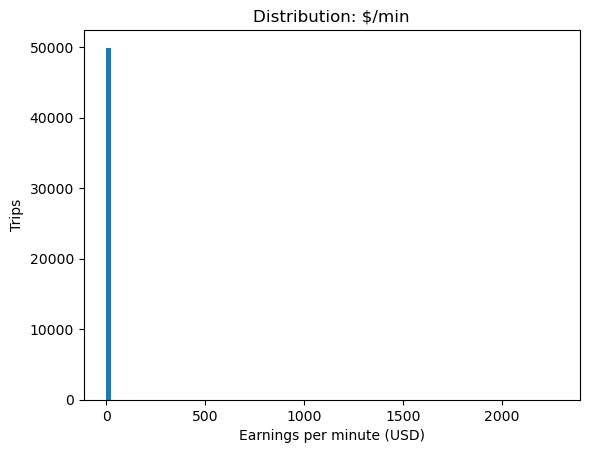

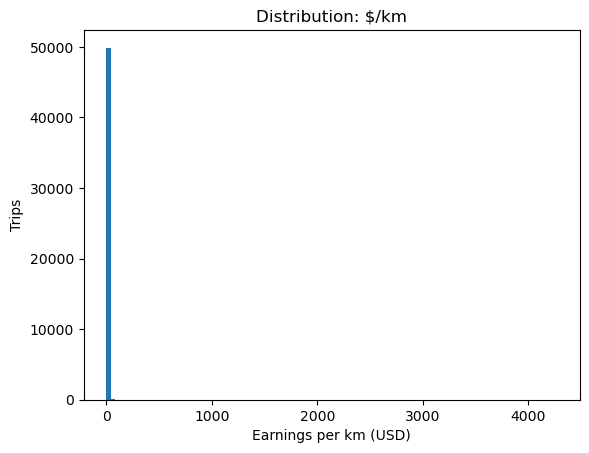

In [20]:
# sample for plotting (keeps it quick)
pdf = (
    df2.select("earnings_per_min","earnings_per_km","trip_distance")
       .sample(False, 0.005, seed=42)   # ~0.5%
       .limit(50000)                    # hard cap
       .toPandas()
)

import matplotlib.pyplot as plt

plt.hist(pdf["earnings_per_min"].dropna(), bins=100)
plt.xlabel("Earnings per minute (USD)")
plt.ylabel("Trips")
plt.title("Distribution: $/min")
plt.show()

plt.hist(pdf["earnings_per_km"].dropna(), bins=100)
plt.xlabel("Earnings per km (USD)")
plt.ylabel("Trips")
plt.title("Distribution: $/km")
plt.show()

/opt/anaconda3/bin/python
Name: pandas
Version: 2.3.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

 Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
 All rights reserved.

 Copyright (c) 2011-2023, Open source contributors.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the

In [2]:
import pandas, pyarrow, pyspark
print("pandas:", pandas.__version__)
print("pyarrow:", pyarrow.__version__)
print("pyspark:", pyspark.__version__)
# optional guards
from packaging.version import Version
assert Version(pandas.__version__) >= Version("2.2")
assert Version(pyarrow.__version__) >= Version("14.0.0")

pandas: 2.3.2
pyarrow: 16.1.0
pyspark: 4.0.0
